# Regression

In [1]:
import sys

sys.path.insert(0, "/home/kleyton/hai/holisticai/src")

In [2]:
from holisticai.datasets import load_dataset
from sklearn.metrics import mean_squared_error

dataset = load_dataset('us_crime', preprocessed=False)
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['train']
test = dataset['test']

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

numeric_features = train['X'].select_dtypes(exclude=['object']).columns.tolist()
categorical_features = train['X'].select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        #('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ])

def transform_to_df(pipeline, X, numeric_features, categorical_features, preprocessor):
    transformed_data = pipeline.transform(X)
    #ohe = preprocessor.named_transformers_['cat']
    #categorical_ohe_columns = ohe.get_feature_names_out(categorical_features).tolist()
    all_feature_names = numeric_features# + categorical_ohe_columns
    return pd.DataFrame(transformed_data, columns=all_feature_names)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
pipeline.fit(train["X"])
Xt_train = transform_to_df(pipeline, train["X"], numeric_features, categorical_features, preprocessor)
Xt_test = transform_to_df(pipeline, test["X"], numeric_features, categorical_features, preprocessor)
yt_train = train["y"]
yt_test = test["y"]

In [3]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from holisticai.utils import RegressionProxy

models = {}

model = RandomForestRegressor(random_state=42)
model.fit(Xt_train, train['y'])
models["RandomForestRegressor"] = RegressionProxy(predict=model.predict)

model = BayesianRidge()
model.fit(Xt_train, train['y'])
models["BayesianRidge"] = RegressionProxy(predict=model.predict)

model = LinearRegression()
model.fit(Xt_train, train['y'])
models["LinearRegression"] = RegressionProxy(predict=model.predict)

model = MLPRegressor(hidden_layer_sizes=(300, 200), max_iter=2000, random_state=42, activation='relu')
model.fit(Xt_train, train['y'])
models["MLPRegressor"] = RegressionProxy(predict=model.predict)

# Global Feature Importance Analysis

In [4]:
from utils import partial_dependence_oscilation,rank_alignment

In [5]:
import os
import importlib
import holisticai.utils.feature_importances as feature_importances
importlib.reload(sys.modules['holisticai.utils.feature_importances'])
from holisticai.utils.inspection import compute_partial_dependence
from holisticai.explainability.metrics import spread_divergence, alpha_score
from sklearn.metrics import f1_score
import pandas as pd
from tqdm import tqdm

top_n = 8
results = {}
for model_name,proxy in tqdm(models.items()):
    importances  = feature_importances.compute_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy, n_repeats=5)
    top_feature_names = list(importances.as_dataframe().sort_values('Importance', ascending=False).head(top_n).Variable)
    conditional_feature_importances  = feature_importances.compute_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy, importance_type="conditional", n_repeats=5)
    partial_dependencies = compute_partial_dependence(Xt_test, features=top_feature_names[:top_n], proxy=proxy)
    results[model_name] = {
        'importances':importances,
        'conditional_feature_importances':conditional_feature_importances,
        'partial_dependencies':partial_dependencies
    }

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:21<00:00,  5.45s/it]


In [9]:
import sys
sys.path.insert(0, "/home/kcosta/repos/hai/holisticai/tutorials/explainability/demos")

from holisticai.utils.feature_importances import compute_permutation_feature_importance
from holisticai.utils.inspection import compute_partial_dependence
from holisticai.explainability.metrics import spread_divergence, alpha_score,xai_ease_score
import pandas as pd
from tqdm import tqdm
from metric_utils import partial_dependence_oscilation, rank_alignment
importlib.reload(sys.modules['metric_utils'])
from holisticai.utils import Importances

model_metrics = {}
for model_name,result in tqdm(results.items()):
    importances  = result['importances']
    conditional_feature_importances  = result['conditional_feature_importances']
    partial_dependencies = result['partial_dependencies']
    acc = mean_squared_error(yt_test, models[model_name].predict(Xt_test))
    metrics  = pd.DataFrame(index=['Alpha Score', 'Spread Divergence', 'Fluctuation Ratio', 'XAI Ease', 'Rank Alignment', 'MSE'], columns=['Value', 'Reference'])
    metrics.at['Alpha Score','Value'] = alpha_score(importances)
    metrics.at['Alpha Score','Reference'] = 0
    metrics.at['Spread Divergence','Value'] = 1 - spread_divergence(importances)
    metrics.at['Spread Divergence','Reference'] = 1
    metrics.at['Fluctuation Ratio','Value'] = partial_dependence_oscilation(partial_dependencies, importances, top_n=top_n)
    metrics.at['Fluctuation Ratio','Reference'] = 0
    imp = Importances(values=importances.as_dataframe().Importance.values[:top_n], feature_names=importances.as_dataframe().Variable.values[:top_n])
    metrics.at['XAI Ease','Value'] = xai_ease_score(partial_dependencies, imp)
    metrics.at['XAI Ease','Reference'] = 0
    metrics.at['Rank Alignment','Value'] = rank_alignment(conditional_feature_importances, importances)
    metrics.at['Rank Alignment','Reference'] = 1
    metrics.at['MSE','Value'] = acc
    metrics.at['MSE','Reference'] = 0
    model_metrics[model_name] = metrics

100%|██████████| 4/4 [00:00<00:00, 20.74it/s]


In [10]:
from holisticai.utils import concatenate_metrics
metric_names = ["MSE", "Spread Divergence",	"Fluctuation Ratio", "Rank Alignment"]
print(concatenate_metrics(model_metrics).loc[metric_names].to_latex(float_format="%.4f"))

\begin{tabular}{llllll}
\toprule
 & RandomForestRegressor & BayesianRidge & LinearRegression & MLPRegressor & Reference \\
\midrule
MSE & 0.0198 & 0.0186 & 0.0190 & 0.0311 & 0 \\
Spread Divergence & 0.7174 & 0.5789 & 0.6733 & 0.3125 & 1 \\
Fluctuation Ratio & 0.3074 & 0.0000 & 0.0000 & 0.0280 & 0 \\
Rank Alignment & 0.1960 & 0.3915 & 0.7056 & 0.4040 & 1 \\
\bottomrule
\end{tabular}



In [11]:
concatenate_metrics(model_metrics)

,RandomForestRegressor,BayesianRidge,LinearRegression,MLPRegressor,Reference
Alpha Score,0.089109,0.237624,0.158416,0.524752,0
Spread Divergence,0.717439,0.578866,0.67329,0.312462,1
Fluctuation Ratio,0.307422,0.0,0.0,0.028033,0
XAI Ease,0.9375,1.0,1.0,0.9375,0
Rank Alignment,0.196023,0.391477,0.705556,0.40398,1
MSE,0.019849,0.018593,0.019026,0.031063,0


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance_contrast(model_name, importances, conditional_feature_importances):
    feature_names = []
    for name, cimp in conditional_feature_importances.values.items():
        feature_names += cimp.top_alpha().feature_names
    feature_names = sorted(set(feature_names))[:10]
    
    # Prepare dataframes
    imp_df = importances.as_dataframe().set_index('Variable').rename({'Importance': "Overall"}, axis=1).loc[feature_names]
    cimp_df = [cimp.as_dataframe().set_index('Variable').rename({"Importance": f"label={name}"}, axis=1).loc[feature_names] for name, cimp in conditional_feature_importances.values.items()]
    all_df = pd.concat([imp_df, *cimp_df], axis=1).sort_values(by='Overall', ascending=False)

    # Set bar width and the number of bars
    width = 0.5  # Width of each bar
    num_columns = len(all_df.columns)  # Number of columns to plot

    # Create figure and primary axis
    #fig, ax1 = plt.subplots(figsize=(30, 6), dpi=200)

    # Plot each set of bars with different positions
    x = np.arange(len(all_df))  # Position for each feature

    # Plot conditional importances and Overall importance
    for i, col in enumerate(all_df.columns):  # Exclude the last column (Fluctuation Ratio)
        # stacked bar chart for class
        if i == 0:
            data = all_df[col]
            plt.bar(x, all_df[col], width=width, label=col, bottom=0)
        else:
            plt.bar(x, all_df[col], width=width, label=col, bottom=data)
            data += all_df[col]

    # Set axis labels and title
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'[{model_name}]')
    plt.tick_params(axis='x', rotation=90)
    plt.xticks(x, labels=all_df.index)

    plt.legend()
    plt.tight_layout()
    plt.tight_layout()

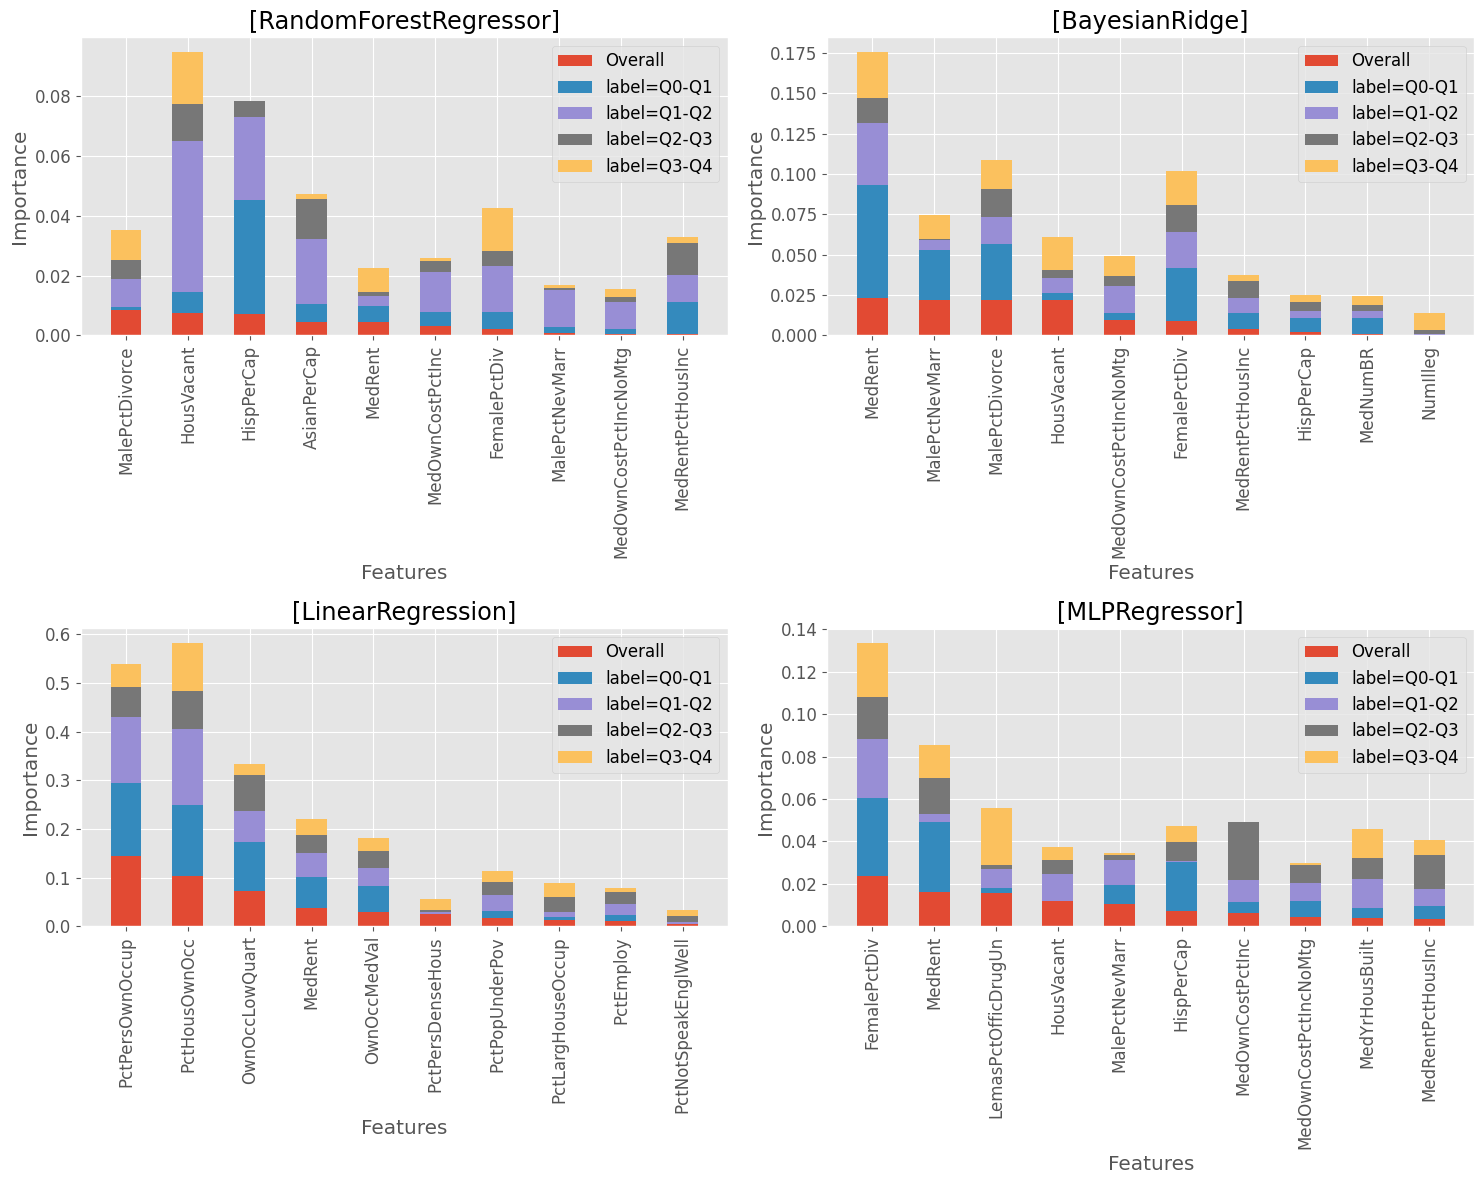

In [13]:
import os
import matplotlib.pyplot as plt
#from utils import plot_feature_importance_contrast

plt.figure(figsize=(15, 12))
for i,(model_name, result) in enumerate(results.items()):
    os.makedirs(model_name, exist_ok=True)
    importances = result['importances']
    conditional_feature_importances = result['conditional_feature_importances']
    proxy=models[model_name]
    plt.subplot(2,2,i+1)
    plot_feature_importance_contrast(model_name, importances, conditional_feature_importances)
plt.savefig(f"feature_importance_contrast.png")

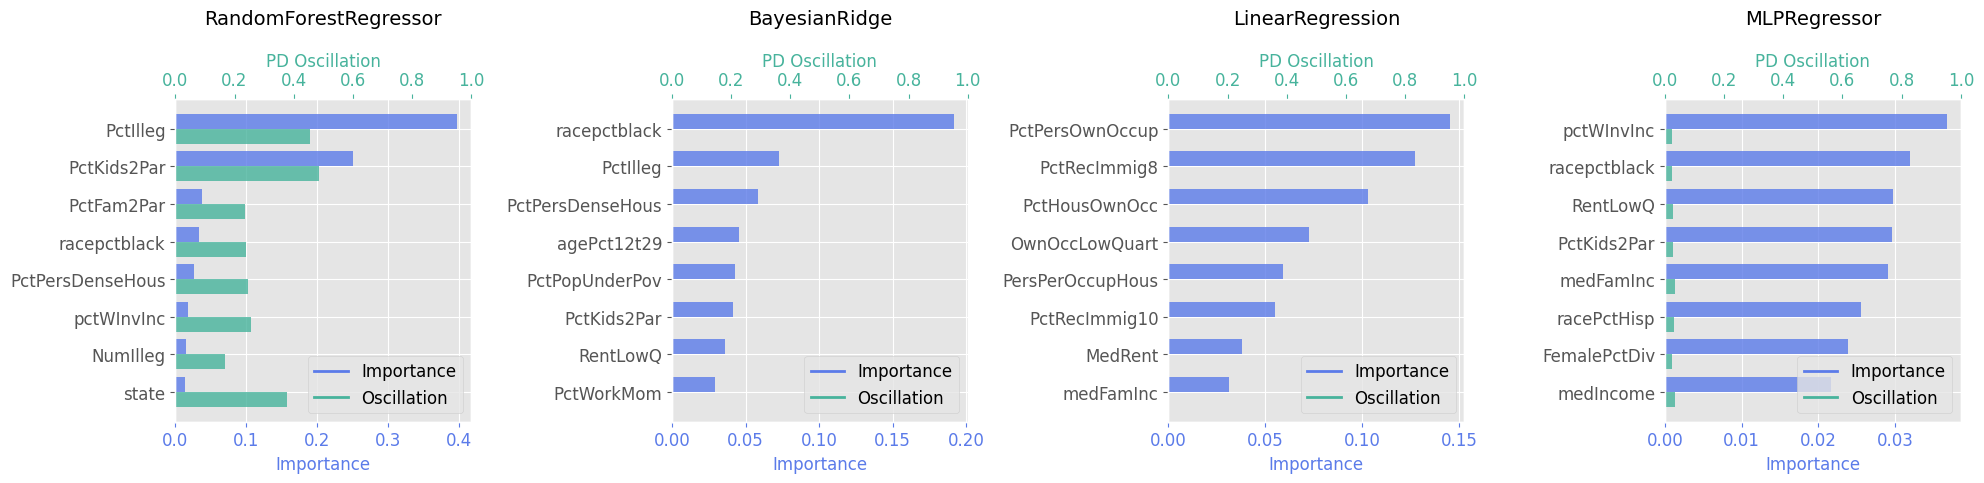

In [15]:
# def plot_feature_importance_partial_dependencies_oscillation(model_name, df, top_n=None):#, figsize=None):
#     if top_n is not None:
#         df = df.iloc[:top_n]
#     # Create positions for the bars
#     features = df['Variable']
#     x_pos = np.arange(len(features))
#     # Create horizontal lollipop chart
#     plt.hlines(y=range(len(df)), xmin=0, xmax=df['Importance'], color='#5B7BE9', alpha=0.7, linewidth=2)
#     plt.plot(df['Importance'], range(len(df)), "o", markersize=8, color='#5B7BE9', alpha=0.8)
#     # Add oscillation markers
#     # Customize the plot
#     plt.yticks(range(len(df)), df['Variable'])
#     plt.xlabel('Value', fontsize=12)
#     # Add a second x-axis for oscillation
#     plt.gca().invert_yaxis()
#     ax1 = plt.gca()
#     ax2 = ax1.twiny()
#     ax2.plot(df['Oscillation'], range(len(df)), "D", markersize=7, color='#47B39C', alpha=0.8)
#     ax2.set_xlim(-0.1, 1)

#     #ax2.set_xlim(ax1.get_xlim())
#     # Set labels and titles
#     ax1.set_xlabel('Importance', color='#5B7BE9', fontsize=12)
#     ax2.set_xlabel('PD Oscillation', color='#47B39C', fontsize=12)
#     plt.title(f'{model_name}', fontsize=14, pad=20)
#     ax2.grid(False)
#     # Add legend
#     from matplotlib.lines import Line2D
#     legend_elements = [
#         Line2D([0], [0], marker='o', color='#5B7BE9', label='Importance',
#             markerfacecolor='#5B7BE9', markersize=8, linewidth=2),
#         Line2D([0], [0], marker='D', color='#47B39C', label='Oscillation',
#             markerfacecolor='#47B39C', markersize=7, linestyle='None')
#     ]
#     ax1.legend(handles=legend_elements, loc='lower right')

#def get_importance_oscillation_table(partial_dependencies, ranked_importances):
#    ocilations = partial_dependence_oscilation(partial_dependencies, aggregated=False)
#    idf = ranked_importances.as_dataframe().set_index('Variable')
#    odf = pd.DataFrame(ocilations, index=partial_dependencies.feature_names, columns=['Oscillation'])
#    return pd.concat([idf, odf], axis=1).reset_index().rename({'index': 'Variable'}, axis=1).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
from metric_utils import get_importance_oscillation_table
from plot_utils import plot_feature_importance_partial_dependencies_oscillation
importlib.reload(sys.modules['plot_utils'])
#from utils import get_importance_oscillation_table
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20, 5))

for i,(model_name, result) in enumerate(results.items()):
    df = get_importance_oscillation_table(result['partial_dependencies'], result['importances'], top_n=top_n)
    plt.subplot(1,4,i+1)
    plot_feature_importance_partial_dependencies_oscillation(model_name, df, top_n=10)
plt.tight_layout()
plt.savefig('feature_importance.pdf')

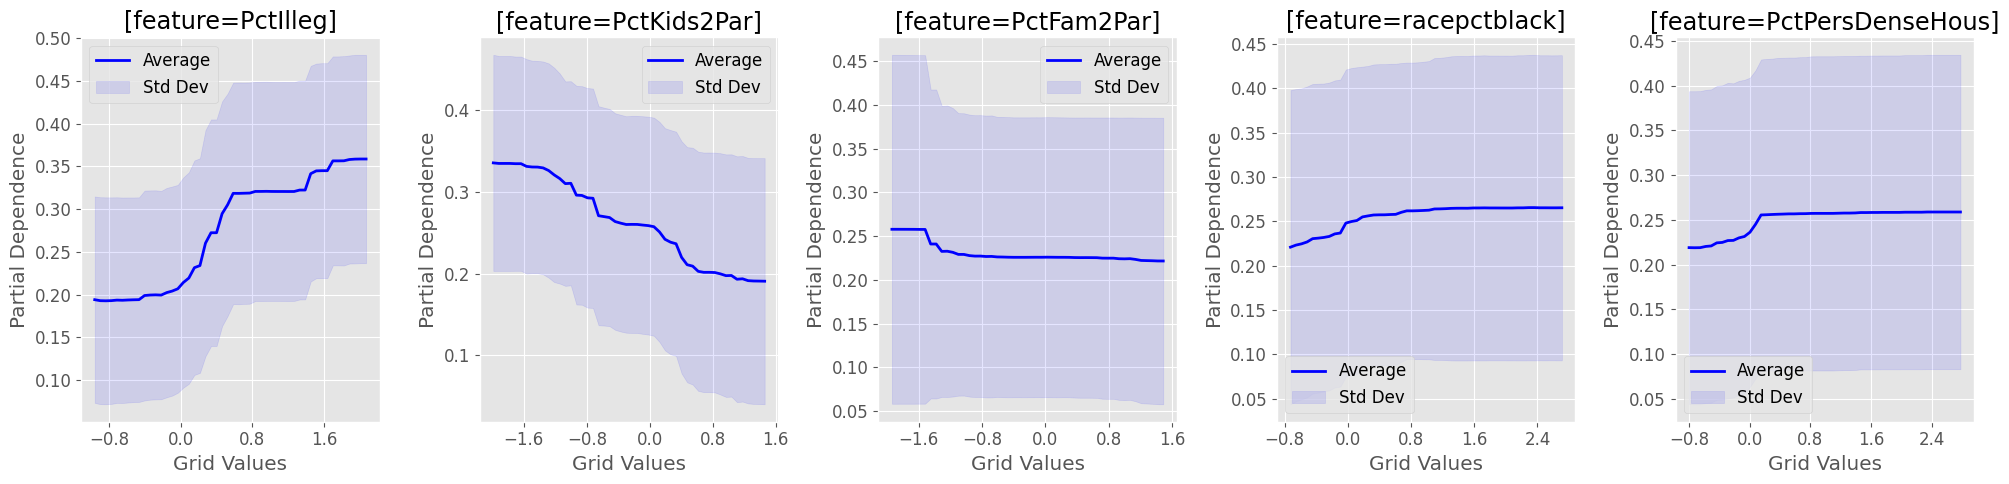

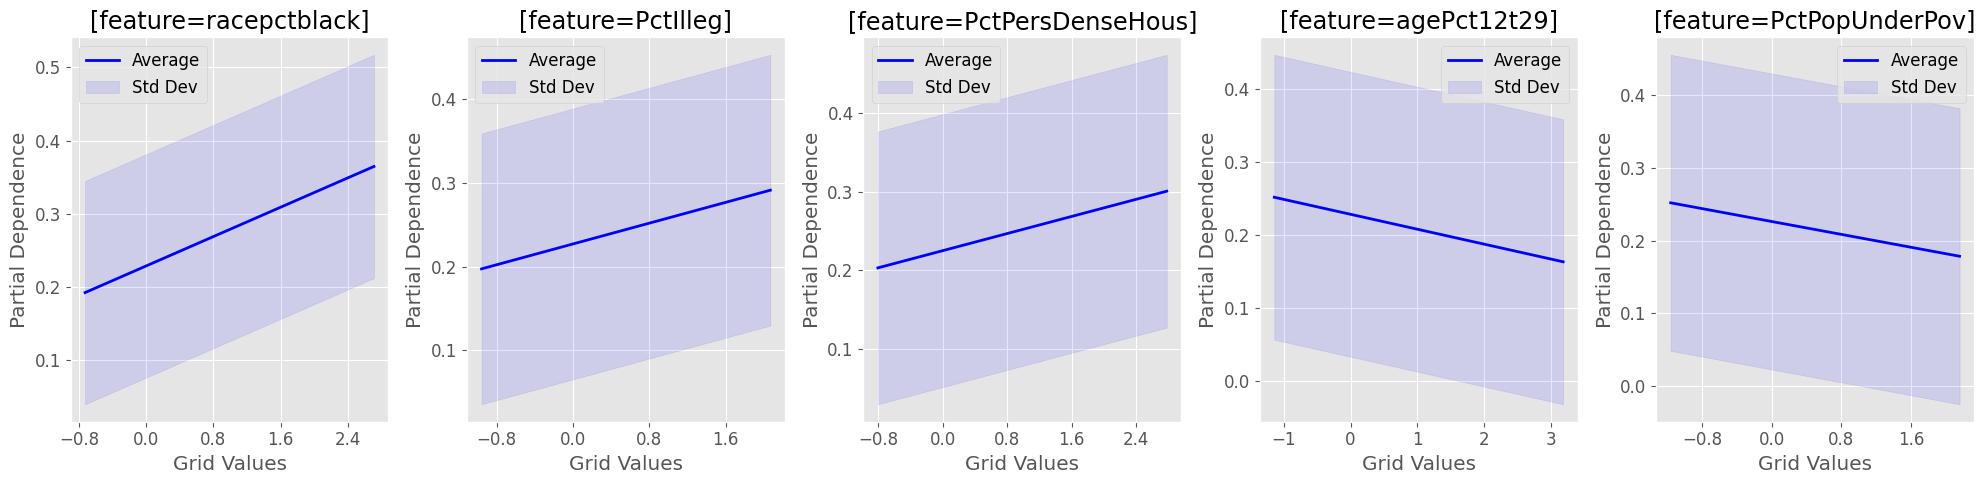

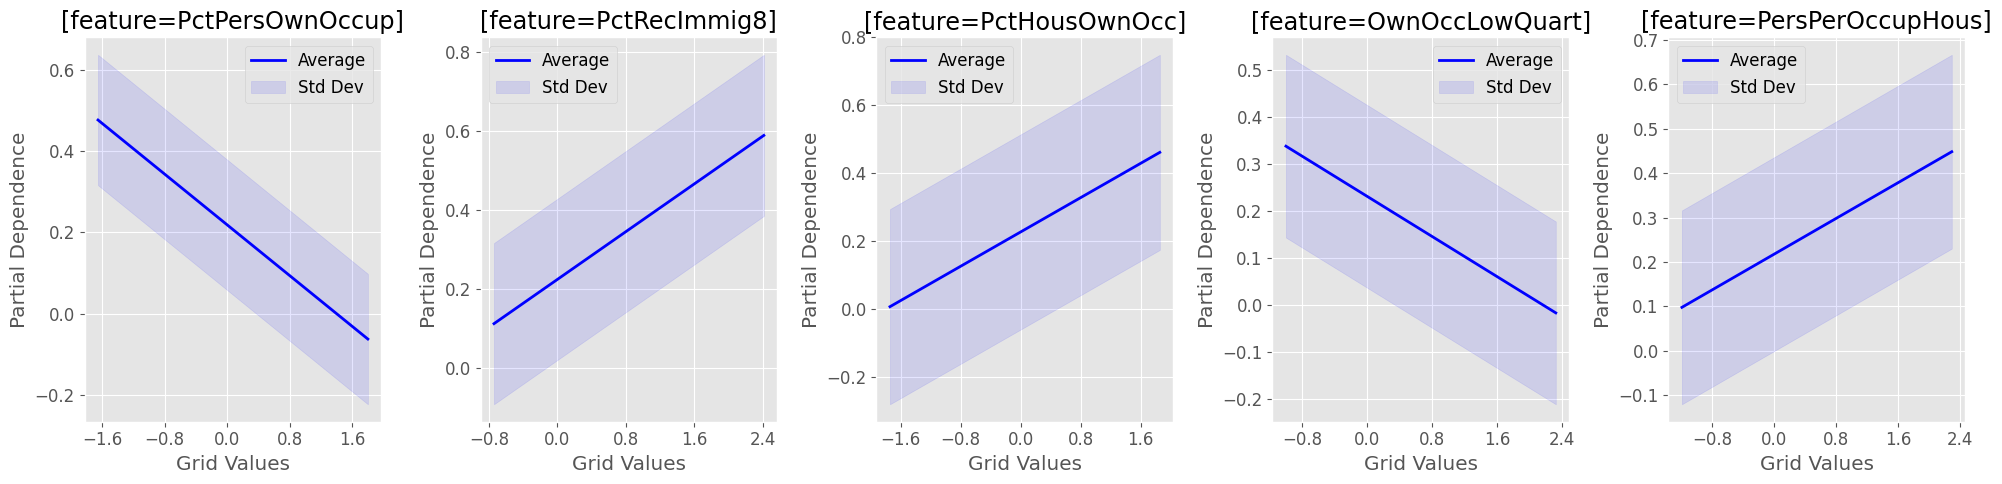

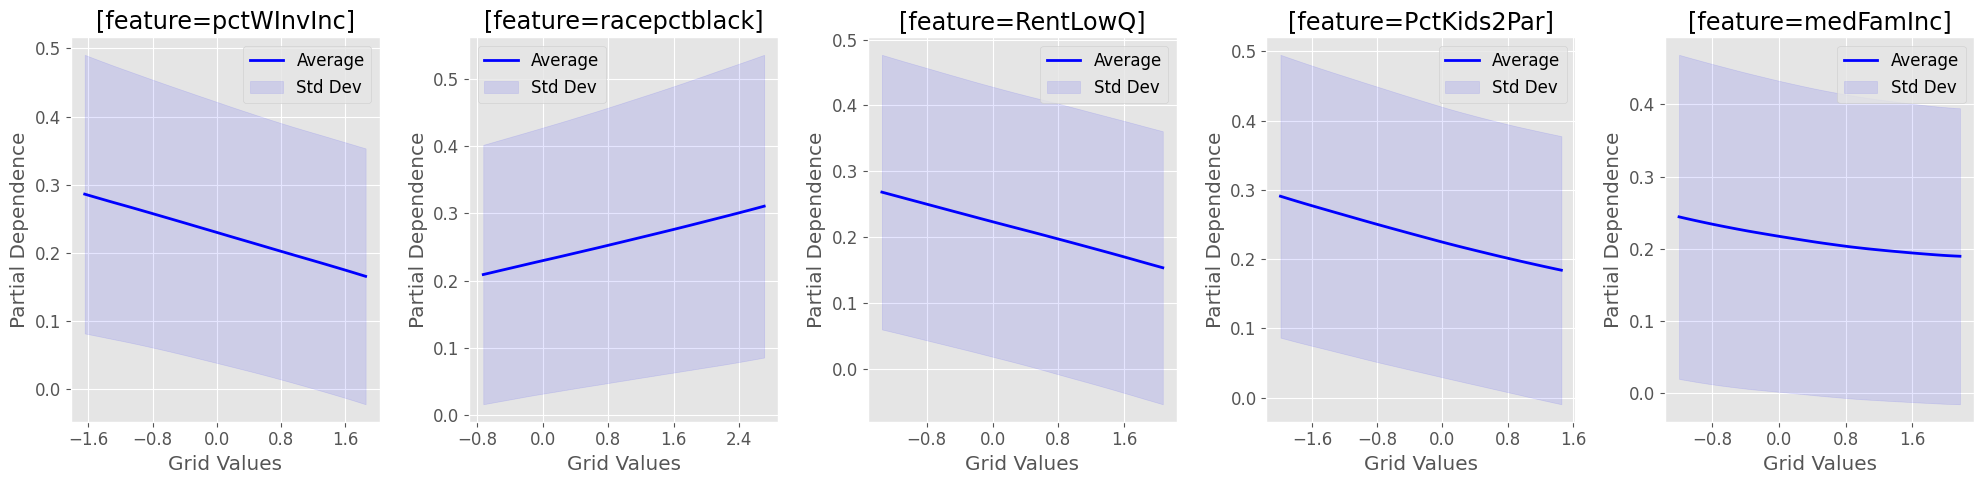

In [16]:
from holisticai.explainability.plots import plot_feature_importance
import os
import matplotlib.pyplot as plt
importlib.reload(sys.modules['plot_utils'])
from plot_utils import plot_partial_dependence_with_std, plot_partial_dependence_oscilation
for model_name, result in results.items():
    partial_dependencies = result['partial_dependencies']
    #partial_dependencies.feature_names = [index2featurenames[i] for i in partial_dependencies.feature_names]
    importances = result['importances']
    #importances.feature_names = [index2featurenames[i] for i in importances.feature_names]
    df = get_importance_oscillation_table(partial_dependencies, importances, top_n=top_n)
    os.makedirs(model_name, exist_ok=True)
    plot_partial_dependence_with_std(partial_dependencies, feature_names=df['Variable'].values, top_n=5)
    plt.savefig(os.path.join(model_name, 'partial_dependence.png'))
    #plot_partial_dependence_oscilation(result['partial_dependencies'], feature_names=df['Variable'].values)
    #plt.savefig(os.path.join(model_name, 'partial_dependence_oscilation.png'))

# Local Feature Importance Analysis

In [17]:
from holisticai.utils.feature_importances import compute_shap_feature_importance
from utils import feature_rank_stability, feature_importance_stability
X = Xt_train

local_model_metrics = {}
local_results = {}
for model_name,model in models.items():
    local_importances = compute_shap_feature_importance(X=X, proxy=model, max_samples=1000, random_state=42)
    local_conditional_importances = local_importances.conditional()
    importances = local_importances.to_global()
    conditional_importances = local_conditional_importances.to_global()

    metrics  = pd.DataFrame(index=['Feature Rank Stability', 'Feature Importance Stability'], columns=['Value', 'Reference'])
    metrics.at['Feature Rank Stability','Value'] = feature_rank_stability(local_importances.values)
    metrics.at['Feature Rank Stability','Reference'] = 0

    metrics.at['Feature Importance Stability','Value'] = feature_importance_stability(local_importances.values)
    metrics.at['Feature Importance Stability','Reference'] = 0
    local_model_metrics[model_name] = metrics
    local_results[model_name] = {'importances':importances, 'conditional_importances':conditional_importances, 'local_importances':local_importances, 'local_conditional_importances':local_conditional_importances}

PermutationExplainer explainer: 1595it [04:53,  5.29it/s]                          
PermutationExplainer explainer: 1595it [00:53, 23.32it/s]                          
PermutationExplainer explainer: 1595it [01:00, 21.24it/s]                          
PermutationExplainer explainer: 1595it [20:26,  1.28it/s]                             


In [18]:
metric_names = ["Feature Rank Stability",	"Feature Importance Stability"]
from holisticai.utils import concatenate_metrics
print(concatenate_metrics(local_model_metrics).loc[metric_names].to_latex(float_format="%.4f"))

\begin{tabular}{llllll}
\toprule
 & RandomForestRegressor & BayesianRidge & LinearRegression & MLPRegressor & Reference \\
\midrule
Feature Rank Stability & 0.7893 & 0.8184 & 0.8364 & 0.7215 & 0 \\
Feature Importance Stability & 0.9972 & 0.9944 & 0.9825 & 0.9825 & 0 \\
\bottomrule
\end{tabular}



In [19]:
model_names = ['RandomForestRegressor', 'BayesianRidge', 'LinearRegression', 'MLPRegressor']
metric_names = ["Feature Rank Stability",	"Feature Importance Stability"]
print(concatenate_metrics(local_model_metrics).T.loc[model_names, metric_names].to_latex(float_format="%.3f"))

\begin{tabular}{lll}
\toprule
 & Feature Rank Stability & Feature Importance Stability \\
\midrule
RandomForestRegressor & 0.789 & 0.997 \\
BayesianRidge & 0.818 & 0.994 \\
LinearRegression & 0.836 & 0.983 \\
MLPRegressor & 0.722 & 0.982 \\
\bottomrule
\end{tabular}



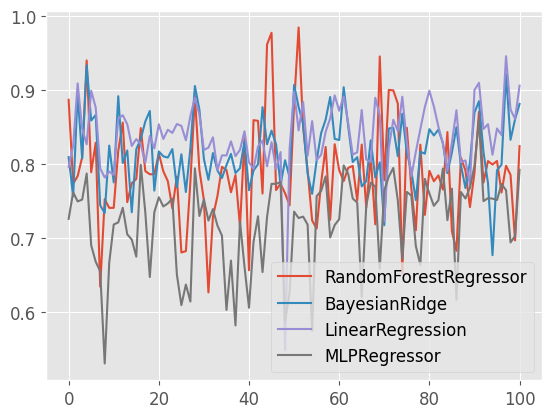

In [20]:
data = local_results['LinearRegression']['local_importances'].data.sort_values(by=('Metadata', 'y'), ascending=False).DataFrame


import matplotlib.pyplot as plt
import numpy as np

from collections import Counter


def feature_rank_stability(local_importances):
    """
    Calculates the rank stability (RSt) for a set of ranked features derived from local feature importances.
    Args:
        local_importances (np.array): A matrix of shape (M, d), where M is the number of samples
                                      and d is the number of features. Each entry represents the importance of a feature in a sample.
    Returns:
        float: The rank stability (RSt) value between 0 and 1.
    """
    # Convert local importances to rankings (higher importance gets a lower rank)
    ranked_features = np.argsort(-local_importances, axis=1)  # Sort each row in descending order, giving ranks
    # Number of iterations
    n = len(ranked_features)
    # Flatten the ranked features list and get the unique features
    unique_features = list(set([feature for iteration in ranked_features for feature in iteration]))
    # Initialize a dictionary to store ranks for each feature
    feature_ranks = {feature: [] for feature in unique_features}
    # Populate ranks for each feature
    for iteration in ranked_features:
        for rank, feature in enumerate(iteration, start=1):
            feature_ranks[feature].append(rank)
    # Calculate rank stability for each feature
    def rank_stability(feature_rankings):
        if len(feature_rankings) == 1:
            return 1.0  # If a feature is ranked only once, its stability is maximal
        # Find the most frequent (consistent) rank
        rank_counter = Counter(feature_rankings)
        most_frequent_rank = rank_counter.most_common(1)[0][0]
        # Calculate actual deviation (sum of absolute differences from the most frequent rank)
        actual_deviation = sum(abs(rank - most_frequent_rank) for rank in feature_rankings)
        # Calculate maximum deviation
        max_deviation = len(feature_rankings) * (max(feature_rankings) - min(feature_rankings))
        if max_deviation == 0:
            return 1.0  # If there's no variation, stability is maximal
        # Calculate and return rank stability
        return 1 - (actual_deviation / max_deviation)
    # Calculate overall rank stability for the system
    data = {feature:rank_stability(feature_ranks[feature]) for feature in unique_features}
    return pd.DataFrame(data, index=[0]).T.reset_index().rename({'index':'Feature', 0:'Rank Stability'}, axis=1)

data_res = pd.DataFrame()
for model in local_results:
    data = feature_rank_stability(local_results[model]['local_importances'].values)
    data_res[model] = data['Rank Stability']
    data_res['Feature'+ model] = data['Feature']
    plt.plot(data['Rank Stability'], label=model)
    plt.legend()

In [21]:
data_res['Mean'] = data_res.mean(axis=1)
data_res

,RandomForestRegressor,FeatureRandomForestRegressor,BayesianRidge,FeatureBayesianRidge,LinearRegression,FeatureLinearRegression,MLPRegressor,FeatureMLPRegressor,Mean
0,0.886961,0,0.809516,0,0.796638,0,0.726154,0,0.402409
1,0.773539,1,0.756530,1,0.824473,1,0.762014,1,0.889570
2,0.783894,2,0.895437,2,0.909126,2,0.749699,2,1.417269
3,0.809408,3,0.807760,3,0.848144,3,0.752215,3,1.902191
4,0.940127,4,0.933516,4,0.826899,4,0.787372,4,2.435989
...,...,...,...,...,...,...,...,...,...
96,0.761747,96,0.799330,96,0.839384,96,0.773237,96,48.396712
97,0.797894,97,0.921654,97,0.945870,97,0.764912,97,48.928791
98,0.785695,98,0.832942,98,0.873712,98,0.694304,98,49.398332
99,0.697098,99,0.860499,99,0.861272,99,0.702848,99,49.890215


In [40]:
local_results['LinearRegression']['local_importances'].data['Serie']

,condition
0,Q0-Q1
1,Q0-Q1
2,Q0-Q1
3,Q0-Q1
4,Q0-Q1
...,...
1589,Q3-Q4
1590,Q3-Q4
1591,Q3-Q4
1592,Q3-Q4


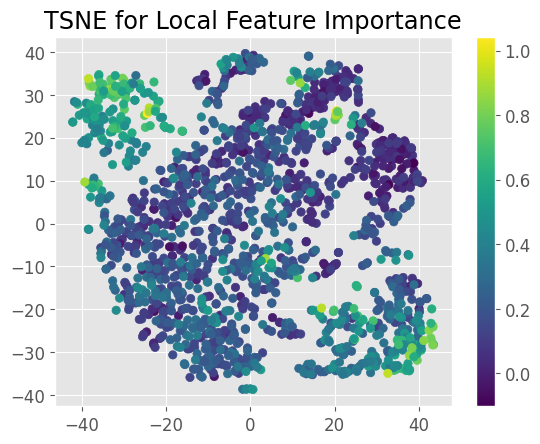

In [44]:
#pd.DataFrame(np.argsort(-local_results['LinearRegression']['local_importances'].values, axis=1))

# tsne for local importance
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = local_results['LinearRegression']['local_importances'].values
label = local_results['LinearRegression']['local_importances'].data['Metadata']['y']

local_results['LinearRegression']['local_importances']
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(data)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=label)
plt.colorbar()
plt.title('TSNE for Local Feature Importance')
#plt.savefig('tsne_local_importance.png')
plt.show()



<Axes: >

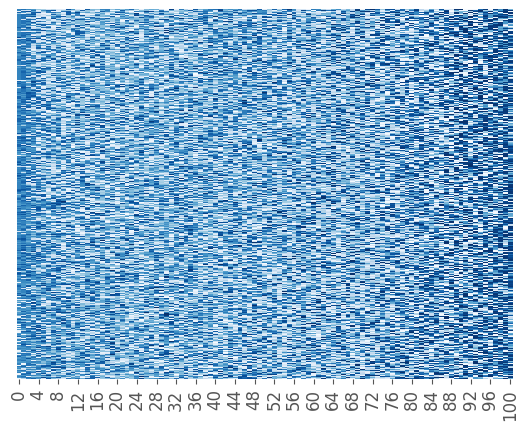

In [24]:
import seaborn as sns
import numpy as np
data = np.argsort(-local_results['LinearRegression']['local_importances'].values)
sns.heatmap(data, cmap='Blues', cbar=False, yticklabels=False)

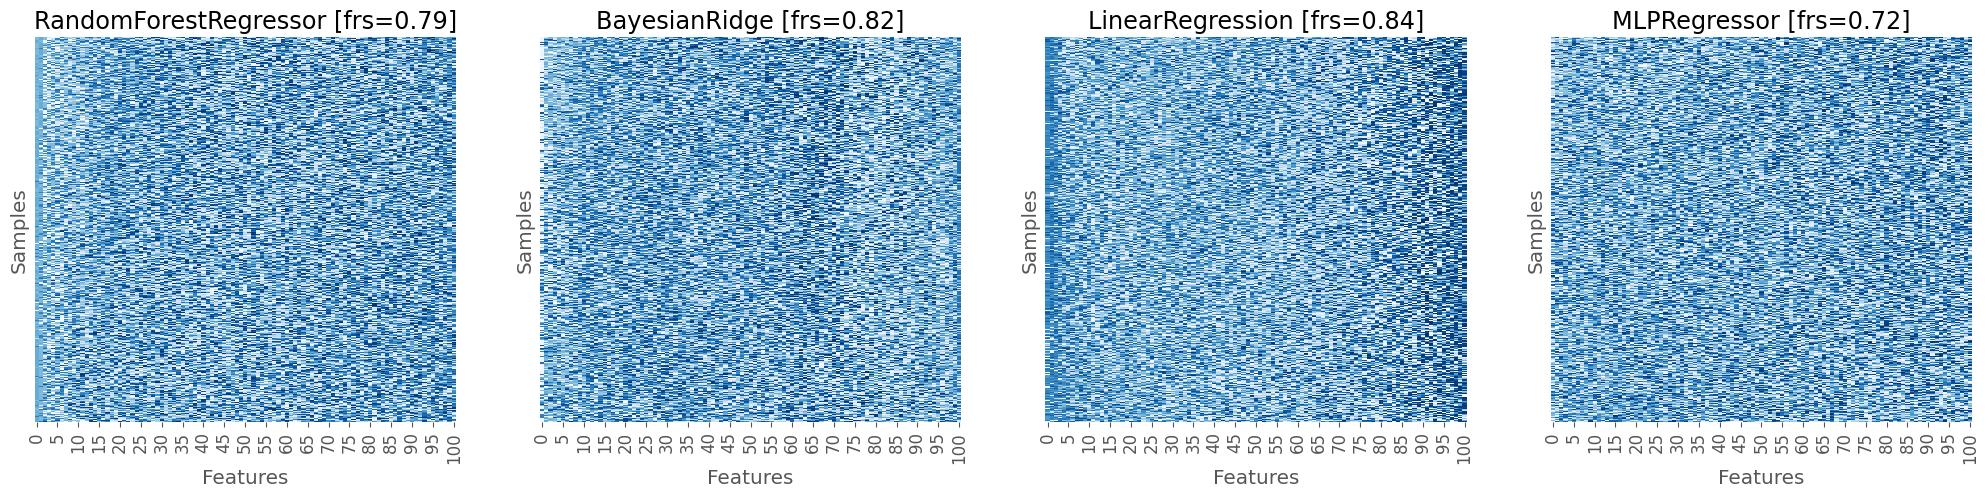

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import plot_feature_ranking

plt.figure(figsize=(25, 5))
for i,(model_name,result) in enumerate(local_results.items()):
    plt.subplot(1,4,i+1)
    frs = local_model_metrics[model_name].loc['Feature Rank Stability','Value']
    title = f"{model_name} [frs={frs:.2f}]"
    plot_feature_ranking(result['local_importances'], title)
plt.savefig('local_feature_ranking.png',bbox_inches='tight')

# Surrogate Analysis

In [26]:
from holisticai.utils import concatenate_metrics
from holisticai.explainability.metrics import surrogate as surrogate_metrics

surrogate_results = {}
surrogates = {}
for model_name,model in models.items():
    
    y_pred = model.predict(Xt_train)
    acc = mean_squared_error(train['y'], y_pred)

    metrics, surrogate = surrogate_metrics.regression_surrogate_explainability_metrics(Xt_train, train['y'], y_pred, surrogate_type="tree", metric_type="all", return_surrogate_model=True)

    metrics.at['MSE', 'Value'] = acc
    metrics.at['MSE', 'Reference'] = 0

    surrogate_results[model_name] = metrics
    surrogates[model_name] = surrogate

concatenate_metrics(surrogate_results)    

,RandomForestRegressor,BayesianRidge,LinearRegression,MLPRegressor,Reference
MSE Degradation,1.179896,0.110359,0.138437,1.764981,0.0
Surrogate Fidelity,0.136185,0.143809,0.166739,0.190388,0.0
Features Stability,1.000000,0.998020,0.996040,0.990099,1.0
Feature Importances Stability,0.211694,0.995574,0.985371,0.664522,1.0
Spread Divergence,0.242259,0.159442,0.185677,0.324894,0.0
Number of Features,101.000000,101.000000,101.000000,100.000000,1.0
Number of Rules,1001.000000,1007.000000,1010.000000,1013.000000,1.0
Tree Depth Variance,10.379319,5.900853,12.685172,18.820838,0.0
Weighted Average Explainability Score,11.822886,10.997021,11.885149,13.677196,0.0
Weighted Average Depth,12.880597,11.766634,12.627723,14.292201,0.0


In [27]:
model_names = ['RandomForestRegressor', 'BayesianRidge', 'LinearRegression', 'MLPRegressor']
metric_names = ["Surrogate Fidelity", "MSE Degradation", "Features Stability","Feature Importances Stability","Spread Divergence", "MSE"]
print(concatenate_metrics(surrogate_results).loc[metric_names].to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrr}
\toprule
 & RandomForestRegressor & BayesianRidge & LinearRegression & MLPRegressor & Reference \\
\midrule
Surrogate Fidelity & 0.1362 & 0.1438 & 0.1667 & 0.1904 & 0.0000 \\
MSE Degradation & 1.1799 & 0.1104 & 0.1384 & 1.7650 & 0.0000 \\
Features Stability & 1.0000 & 0.9980 & 0.9960 & 0.9901 & 1.0000 \\
Feature Importances Stability & 0.2117 & 0.9956 & 0.9854 & 0.6645 & 1.0000 \\
Spread Divergence & 0.2423 & 0.1594 & 0.1857 & 0.3249 & 0.0000 \\
MSE & 0.0026 & 0.0168 & 0.0161 & 0.0006 & 0.0000 \\
\bottomrule
\end{tabular}



In [29]:
model_names = ['RandomForestRegressor', 'BayesianRidge', 'LinearRegression', 'MLPRegressor']
metric_names = ["Surrogate Fidelity", "MSE Degradation", "Features Stability","Feature Importances Stability","Spread Divergence", "MSE"]
print(concatenate_metrics(surrogate_results).T.loc[model_names, metric_names].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
 & Surrogate Fidelity & MSE Degradation & Features Stability & Feature Importances Stability & Spread Divergence & MSE \\
\midrule
RandomForestRegressor & 0.136 & 1.180 & 1.000 & 0.212 & 0.242 & 0.003 \\
BayesianRidge & 0.144 & 0.110 & 0.998 & 0.996 & 0.159 & 0.017 \\
LinearRegression & 0.167 & 0.138 & 0.996 & 0.985 & 0.186 & 0.016 \\
MLPRegressor & 0.190 & 1.765 & 0.990 & 0.665 & 0.325 & 0.001 \\
\bottomrule
\end{tabular}



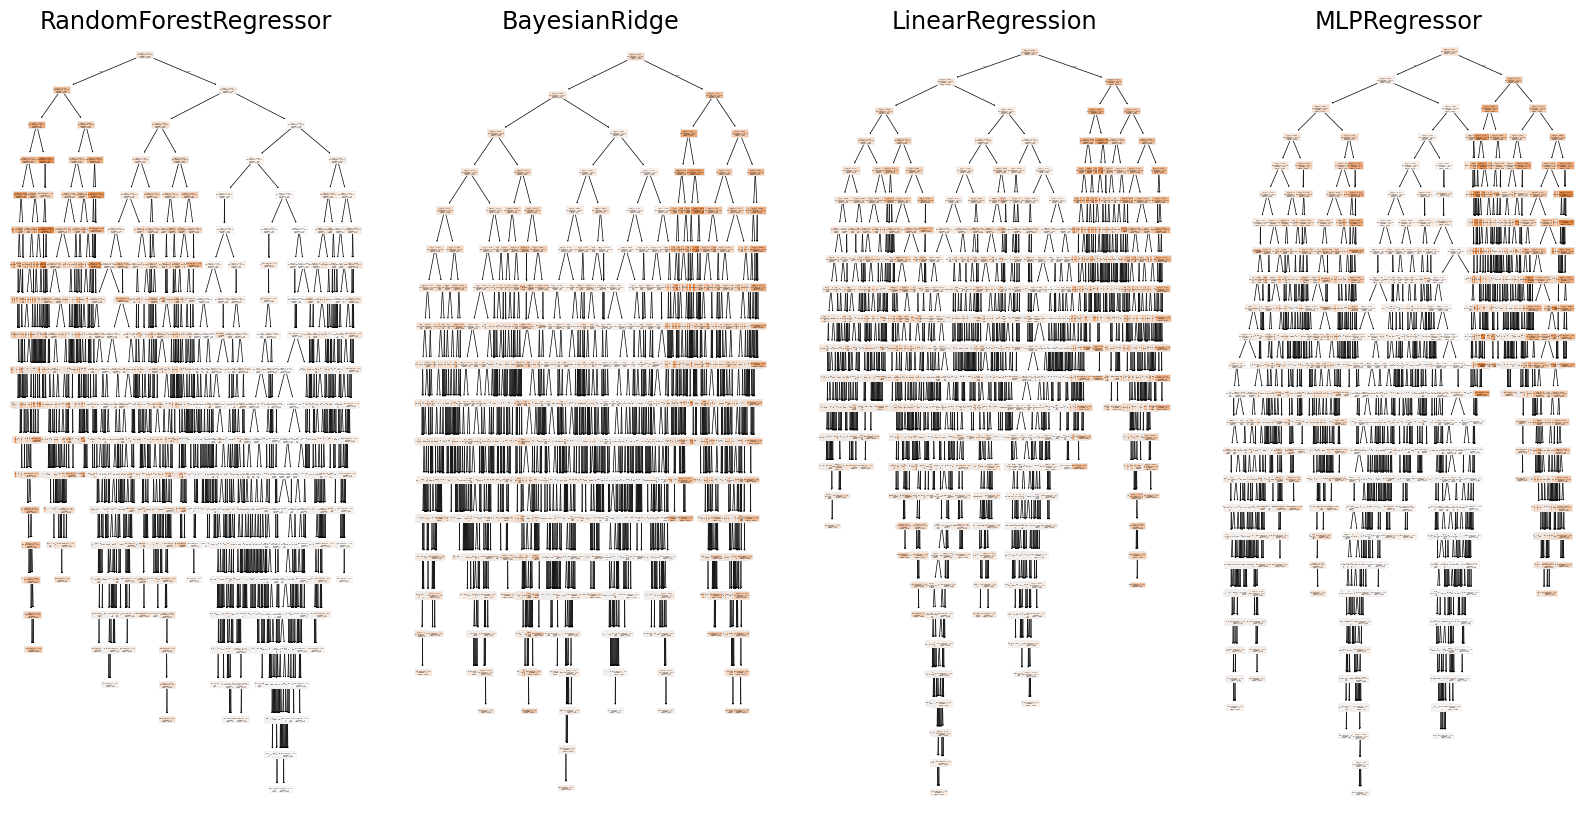

In [30]:
from sklearn.tree import plot_tree
_,axes = plt.subplots(1,4, figsize=(20,10))


for i,(model_name,surrogate) in enumerate(surrogates.items()):
    plt.subplot(1,len(surrogates),i+1)
    plot_tree(surrogate._surrogate, filled=True, ax=axes[i])
    axes[i].set_title(model_name)
plt.savefig("surrogate_tree.png")

In [31]:
from holisticai.explainability.metrics import surrogate as surrogate_metrics

surrogate_results = {}
surrogates = {}
for model_name,model in models.items():
    
    y_pred = model.predict(Xt_train)
    acc = mean_squared_error(train['y'], y_pred)

    metrics, surrogate = surrogate_metrics.regression_surrogate_explainability_metrics(Xt_train, train['y'], y_pred, surrogate_type="shallow_tree", metric_type="performance", return_surrogate_model=True)

    metrics.at['MSE', 'Value'] = acc
    metrics.at['MSE', 'Reference'] = 0

    surrogate_results[model_name] = metrics
    surrogates[model_name] = surrogate

concatenate_metrics(surrogate_results) 

,RandomForestRegressor,BayesianRidge,LinearRegression,MLPRegressor,Reference
MSE Degradation,1.562385,0.306484,0.324200,1.884834,0.0
Surrogate Fidelity,0.369312,0.369902,0.411933,0.477368,0.0
MSE,0.002590,0.016753,0.016081,0.000621,0.0
